In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random
import shutil
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
from IPython.display import clear_output
import torch

In [ ]:
!! unzip data.zip

In [2]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()


,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [3]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [4]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [5]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [6]:
######################

In [7]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [8]:
dictionary = make_dictionary(all_codones)

In [234]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [12]:
######################

In [86]:
def frequency(all_codones, dictionary):
    freq = {}
    for line in all_codones:
        for cod in line:
            if dictionary[cod] not in freq:
                freq[dictionary[cod]] = 0
            freq[dictionary[cod]] += 1
    return freq

In [87]:
freq = frequency(all_codones, dictionary)


In [125]:
arr_freq = np.array(list(freq.items()))
samples = arr_freq[arr_freq[:, 1] > 1000][:, 0]

In [286]:
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.input_embed = torch.nn.Embedding(vocab_size, embed_size, sparse=True).cuda()
        self.out_embed = torch.nn.Embedding(vocab_size, embed_size, sparse=True).cuda()
        self.init_embed()

    def f(self, v):
        num = np.random.randint(0, len(v))

        indx = np.arange(0, len(v))
        np.random.shuffle(indx)
        v[indx[:num]] = 1.0
        return v
    def init_embed(self):
        self.input_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-0, 0)

    def forward(self, centers, targets, neg_samples):
        emb_centers = self.input_embed(torch.cuda.LongTensor(centers))
        emb_targets = self.out_embed(torch.cuda.LongTensor(targets).squeeze())
        
        score = torch.mul(emb_centers, emb_targets).squeeze()
        score = torch.sum(score, dim=1)
        pos_loss = torch.functional.F.logsigmoid(score)
        
        emb_neg_samples = self.out_embed(neg_samples.cuda())
        neg_score = torch.bmm(emb_neg_samples, emb_centers.unsqueeze(2)).squeeze()
        ## вот тут мне кажется чутка напутали?? разве там сначала лог а потом сумма, ощущение что сделали наоборот
        neg_score =  torch.sum(neg_score, dim=1)
        neg_loss = torch.functional.F.logsigmoid(-1 * neg_score)
        
        loss = pos_loss + neg_loss

        return -loss.mean()
    
    def get_input_enbed(self):
        return self.input_embed.weight.data.cpu().numpy()     
    

In [128]:
######################

In [129]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .9
NUM_TRAIN_STEPS = 100000
SKIP_STEP = 5000    

In [130]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [131]:
def get_neg_samples(num_samples, centers, vocab):
    batch_size = len(centers)
    neg = np.zeros((batch_size, num_samples))
    for i in range(batch_size):
        samples = random.sample(vocab, num_samples)
        while centers[i] in samples:
            samples = random.sample(vocab, num_samples)
        neg[i] = samples
    return torch.LongTensor(neg) 

In [285]:
def train(model,batch_gen, num_train_steps, learning_rate, skip_step, num_sampled):
    make_dir('checkpoints')
    logger = SummaryWriter('loss_function')
    optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
    total_loss = 0.0
    temp_count = 1
    for i, batch in enumerate(batch_gen):
        centers, targets = batch
        
        neg_sampling = get_neg_samples(num_sampled, centers, list(samples)) 
        loss = model(centers, targets, neg_sampling)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        total_loss += loss.item()
        if (i + 1) % skip_step == 0:
            cur_loss = total_loss / skip_step
            print(i + 1, cur_loss)
            total_loss = 0.0
            logger.add_scalar('loss', cur_loss, i+1)
            torch.save(model.state_dict(), 'checkpoints/model_step%d.pt' % (i + 1))
            if temp_count % 25 == 0:
                clear_output(wait=True)
                shutil.rmtree('checkpoints/')
                make_dir('checkpoints')
            temp_count += 1
            
    return model.get_input_enbed()    

In [ ]:
model = SkipGram(VOCAB_SIZE, EMBED_SIZE)
print(model.get_input_enbed())
final_embed_matrix = train(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP, NUM_SAMPLED)

In [11]:
######################

In [272]:
final_embed_matrix_nump = model.get_input_enbed()

In [274]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix_nump)

In [275]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,-5.956992,-1.083393,PSF
1,5.761776,-0.290410,DHE
2,-8.614585,-4.127260,SNL
3,-7.929200,-9.360617,XID
4,-4.538513,0.975972,GEG


In [250]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

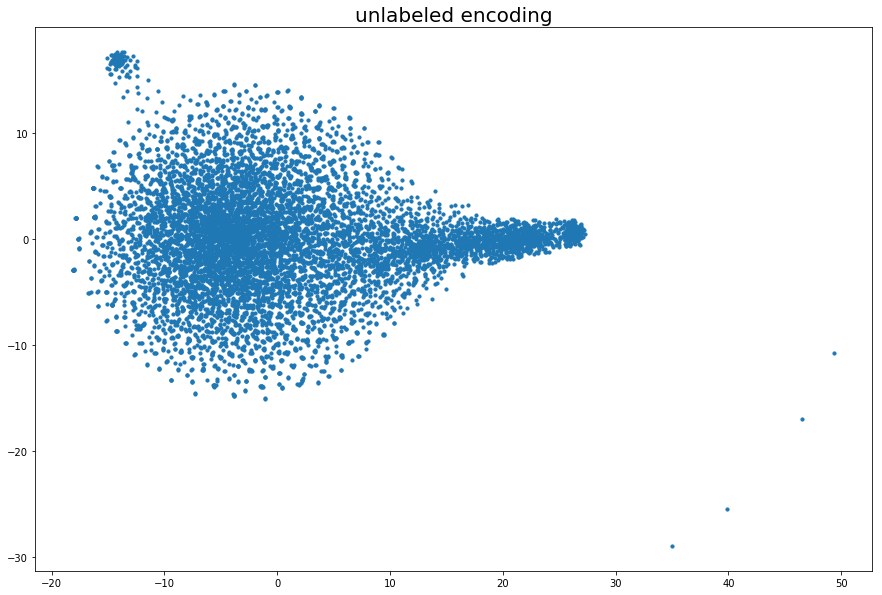

In [276]:
plot_tsne_df(tsne_df)

In [252]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [253]:
######################

In [254]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [255]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [256]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,HLS,-0.066667,112.458067,18.666667,136.300000
1,KEK,-3.766667,128.486200,22.333333,158.533333
2,NSK,-2.733333,109.784067,18.333333,123.900000
3,VNR,-1.266667,123.139800,20.666667,142.500000
4,KTW,-1.833333,138.495367,22.666667,170.833333


In [277]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,HLS,-0.066667,112.458067,18.666667,136.300000,-16.106087,3.140794
1,KEK,-3.766667,128.486200,22.333333,158.533333,-8.549599,-3.397491
2,NSK,-2.733333,109.784067,18.333333,123.900000,-6.738976,-6.074997
3,VNR,-1.266667,123.139800,20.666667,142.500000,-10.822714,-5.007821
4,KTW,-1.833333,138.495367,22.666667,170.833333,-1.247723,-1.739671


In [278]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

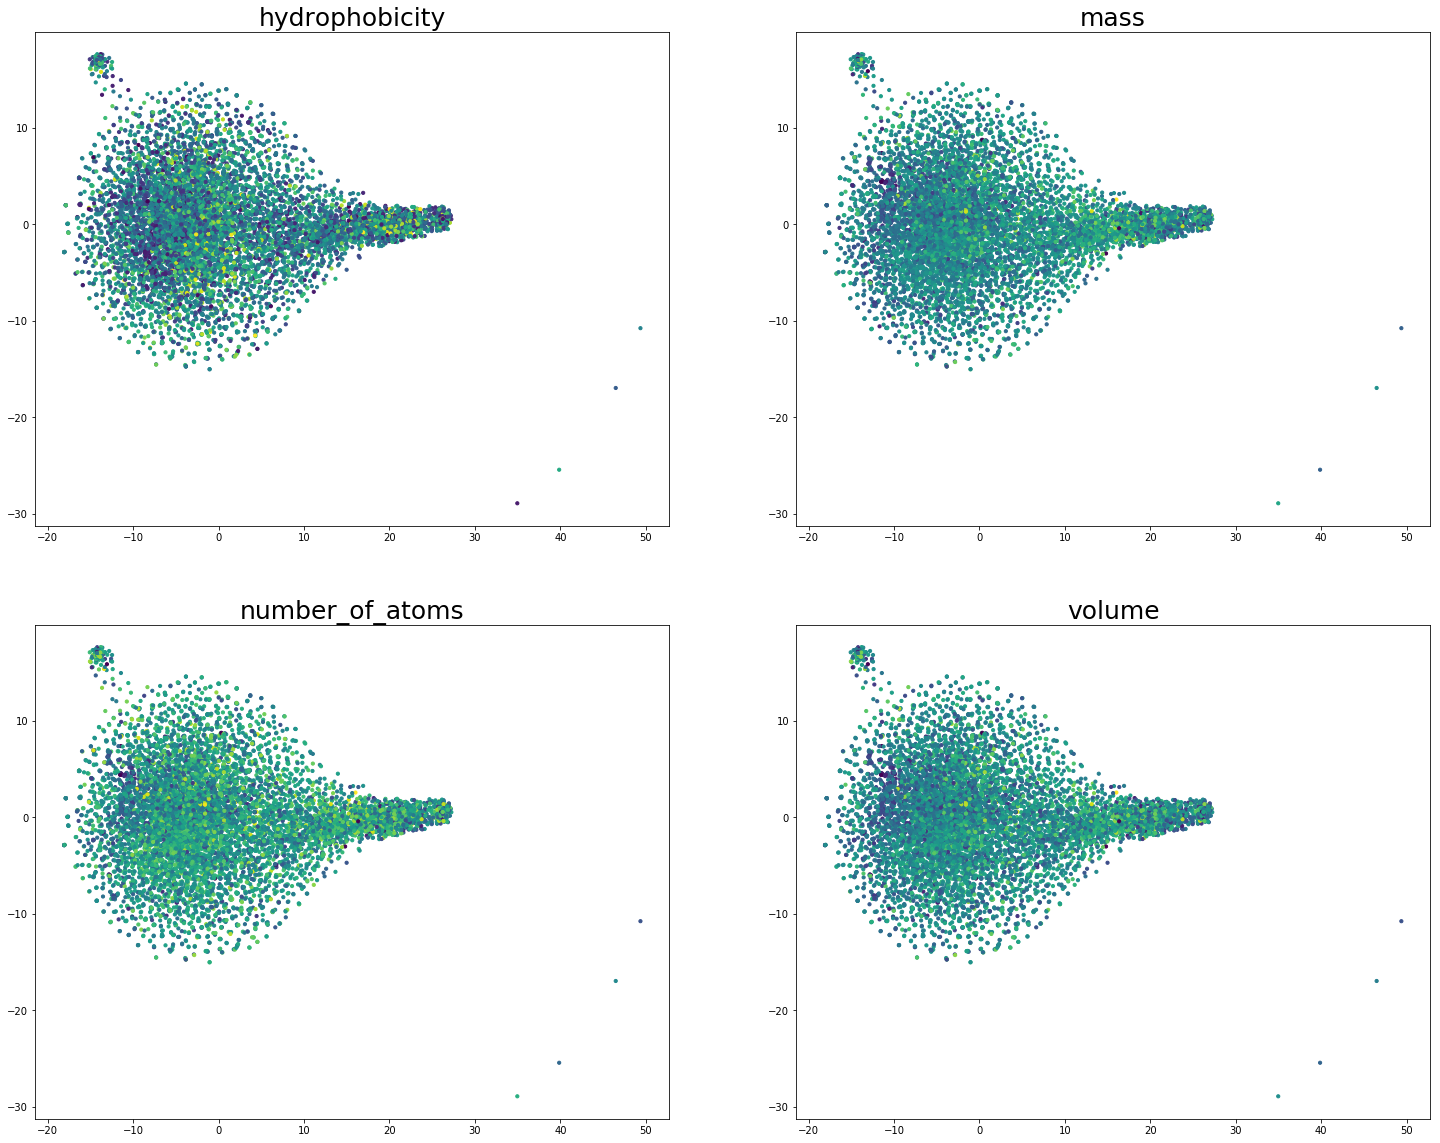

In [279]:
plot_embedding_properties(final_df)

In [28]:
######################

In [91]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

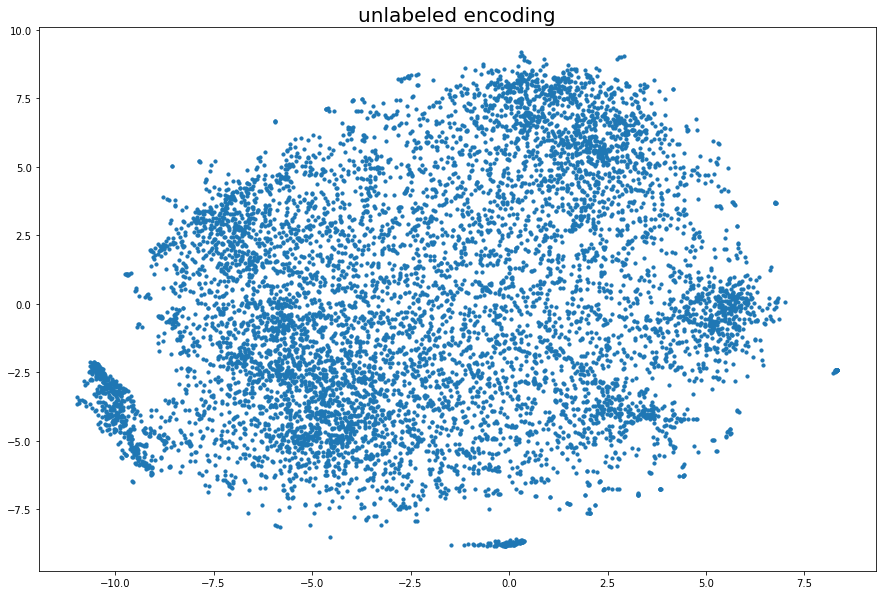

In [96]:
plot_tsne_df(gensim_tsne_df)

In [31]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

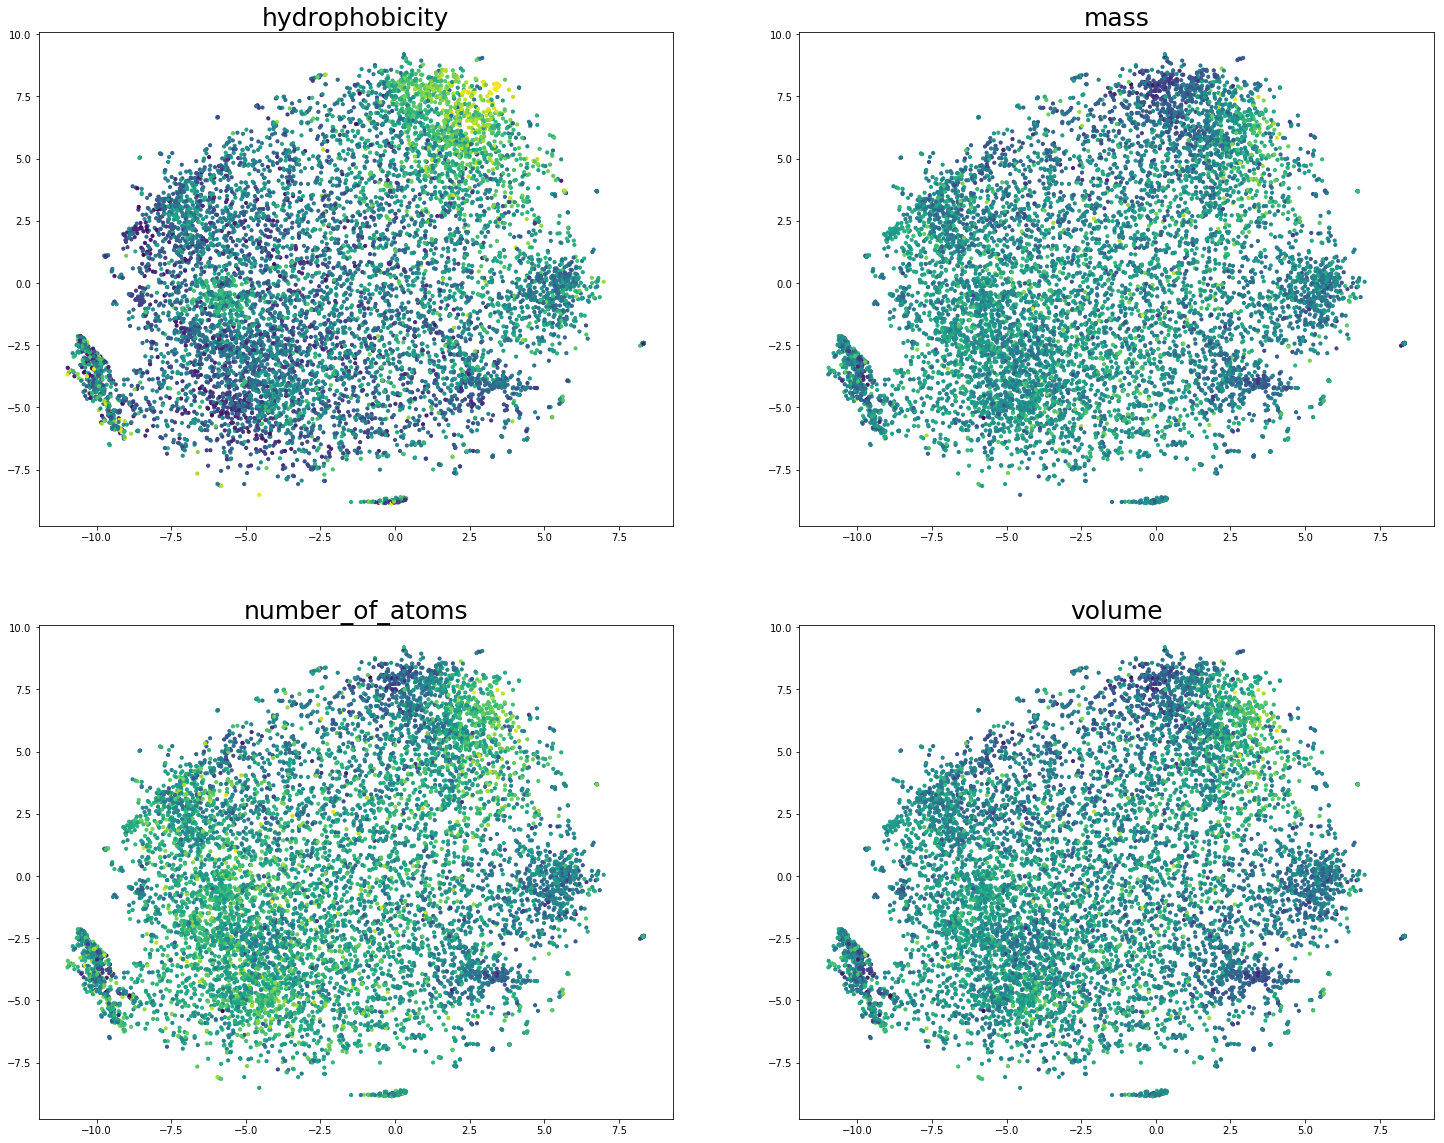

In [32]:
plot_embedding_properties(final_df_nice)

In [ ]:
######################

In [284]:
writer = SummaryWriter('./tensor')
rev_dict = {val:key for key, val in dictionary.items()}
writer.add_embedding(final_embed_matrix_nump,  metadata=final_df['hydrophobicity'])
writer.close()

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [ ]:
soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59